# Pipeline for Industrial Equipment Monitoring

## Introduction
[Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/) helps with building entire workflows

These steps can be triggered automatically by a CI/CD workflow or on demand from a command line or notebook.


**Components** performs a single step in a Machine Learning workflow such (e.g. data ingestion, data preprocessing, data transformation, model training, hyperparameter tuning). 

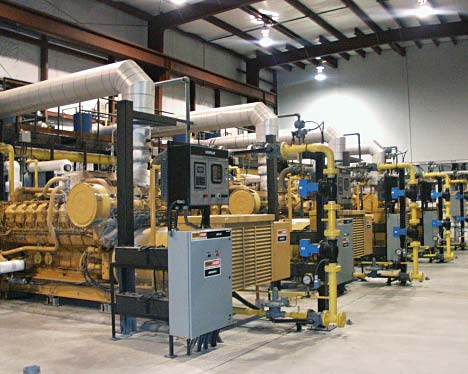

## Prerequisites
check to see if kfp is installed:

In [ ]:
! pip3 show kfp

## 1. Configure access Minio 

### Upload our Training Dataset to Minio

First, we configure credentials for `mc`, the MinIO command line client.
We then use it to create a bucket, upload the dataset to it, and set access policy so that the pipeline can download it from MinIO.

Follow the steps below to download minio client
<div class="alert">
   <code>
    wget https://dl.min.io/client/mc/release/linux-amd64/mc
    chmod +x mc
    ./mc --help
    </code>

</div>

In [ ]:
! wget https://dl.min.io/client/mc/release/linux-amd64/mc
! chmod +x mc
! ./mc --help

#### a. Connect to the Minio Server

In [ ]:
! ./mc alias set minio http://minio-service.kubeflow:9000 minio minio123

#### b. Create a bucket to store your data and export your model to Minio

**Make sure you clear this bucket once you are cone running your pipeline**

In [ ]:
! ./mc mb minio/monitoring 

In [ ]:
! ./mc ls minio mlpipeline

#### c. Upload the dataset to your bucket in Minio.

**Note**: Make sure you have your dataset in a folder like we have here as <code>datasets</code>.

In [ ]:
! tar --dereference -czf datasets.tar.gz ./datasets
! ./mc cp datasets.tar.gz minio/monitoring/datasets.tar.gz
! ./mc policy set download minio/monitoring 

### If you have downloaded your data too many times while testing, use the following code to clear out your bucket

In [ ]:
# ! ./mc rm --recursive --force minio/monitoring

### Minio Server URL and Credentials

In [ ]:
MINIO_SERVER='minio-service.kubeflow:9000'
MINIO_ACCESS_KEY='minio'
MINIO_SECRET_KEY='minio123'

## How to Implement Kubeflow Pipelines Components

In this pipeline, we have the following components:
- Sensor data download component
- Preprocess the dataset component
- Train the model component
- Test model component
- Print Results component
- Export the trained model component

In [ ]:
from typing import NamedTuple
import kfp
import kfp.components as components
import kfp.dsl as dsl
from kfp.components import InputPath, OutputPath #helps define the input & output between the components

### Component 1: Download the  Data Set

In [ ]:
def download_dataset(minio_server: str, data_dir: OutputPath(str)):
    """Download the data set to the KFP volume to share it among all steps"""
    import urllib.request
    import tarfile
    import os
    import subprocess

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    url = f'http://{minio_server}/monitoring/datasets.tar.gz'
    print(url)
    stream = urllib.request.urlopen(url)
    print('done downloading')
    tar = tarfile.open(fileobj=stream, mode="r|gz")
    tar.extractall(path=data_dir)
    print('done extracting')
    
    
    subprocess.call(["ls", "-dlha", data_dir])
    

### Component 2: Preprocess the DataSet

In [ ]:
def preprocessing(data_dir: InputPath(str), clean_data_dir: OutputPath(str)):
    
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pandas'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'sklearn'])
    import numpy as np
    import pandas as pd
    import os
    import pickle
    from sklearn import preprocessing
    
    df = pd.read_csv(f"{data_dir}/datasets/data.csv")
    df = df.drop(['day', 'hour', 'sample_Number', 'month', 'timestamp','mode', 'pCut::Motor_Torque'
                 ,'pCut::CTRL_Position_controller::Lag_error','pSvolFilm::CTRL_Position_controller::Lag_error'], axis=1)
    df = df.fillna(0)
    train_percentage = 0.30
    train_size = int(len(df.index)*train_percentage)
    x_train = df[:train_size]
    x_test = df[train_size:490000]
    scaler = preprocessing.MinMaxScaler()

    X_train = pd.DataFrame(scaler.fit_transform(x_train), 
                                columns=x_train.columns, 
                                index=x_train.index)
    # Random shuffle training data
    X_train.sample(frac=1)

    X_test = pd.DataFrame(scaler.transform(x_test), 
                              columns=x_test.columns, 
                              index=x_test.index)
    data = {"X_train": X_train,"X_test": X_test}
    
    
    os.makedirs(clean_data_dir, exist_ok=True)

    with open(os.path.join(clean_data_dir,'clean_data.pickle'), 'wb') as f:
        pickle.dump(data, f)
    
    print(f"clean_data.pickle {clean_data_dir}")
    
    print(os.listdir(clean_data_dir))

### Component 3: Train the model

In [ ]:
def train(clean_data_dir: InputPath(str), model_dir: OutputPath(str)):
    #importing libraries
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pandas'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'tensorflow'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'keras'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'joblib'])
    import pandas as pd
    import pickle
    import os
    import joblib
    import numpy as np
    import tensorflow as tf
    from keras.layers import Input, Dropout
    from keras.layers.core import Dense 
    from keras.models import Model, Sequential, load_model
    from keras import regularizers

    with open(os.path.join(clean_data_dir,'clean_data.pickle'), 'rb') as f:
        data = pickle.load(f)
        
    print(data) 
    
    np.random.seed(10)
    tf.random.set_seed(10)
    X_train = data['X_train']
    act_func = 'elu'

    # Input layer:
    model=Sequential()
    # First hidden layer, connected to input vector X. 
    model.add(Dense(10,activation=act_func,
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=regularizers.l2(0.0),
                  input_shape=(X_train.shape[1],)
                )
          )

    model.add(Dense(2,activation=act_func,
                  kernel_initializer='glorot_uniform'))

    model.add(Dense(10,activation=act_func,
                  kernel_initializer='glorot_uniform'))

    model.add(Dense(X_train.shape[1],
                  kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')

    # Train model for 100 epochs, batch size of 10: 
    NUM_EPOCHS=5
    BATCH_SIZE=10

    model.fit(np.array(X_train),np.array(X_train),
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_split=0.1,
                    verbose = 1)
    
    os.makedirs(model_dir, exist_ok=True)

    model.save(model_dir + "/model.h5")
    print(f"Model saved {model_dir}")
    print(os.listdir(model_dir))
    

### Component 4: PCA

In [ ]:
def PCA(clean_data_dir: InputPath(str), pca_dir: OutputPath(str)):
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pandas'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'sklean'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'joblib'])
    import pandas as pd
    import numpy as np
    import os
    import pickle
    import joblib
    from sklearn.decomposition import PCA
    
    with open(os.path.join(clean_data_dir,'clean_data.pickle'), 'rb') as f:
        data = pickle.load(f)
        
    print(data)
    
    
    X_train = data['X_train']
    X_test = data['X_test']  
    print(len(X_train),len(X_test))
    pca = PCA(n_components=2, svd_solver= 'full')
    X_train_PCA = pca.fit_transform(X_train)
    X_train_PCA = pd.DataFrame(X_train_PCA)
    X_train_PCA.index = X_train.index

    X_test_PCA = pca.transform(X_test)
    X_test_PCA = pd.DataFrame(X_test_PCA)
    X_test_PCA.index = X_test.index
    
    def is_pos_def(A):

        if np.allclose(A, A.T):
            try:
                np.linalg.cholesky(A)
                return True
            except np.linalg.LinAlgError:
                return False
        else:
            return False
    
    def cov_matrix(data, verbose=False):
        covariance_matrix = np.cov(data, rowvar=False)
        
        if is_pos_def(covariance_matrix):
            inv_covariance_matrix = np.linalg.inv(covariance_matrix)
            if is_pos_def(inv_covariance_matrix):
                return covariance_matrix, inv_covariance_matrix
            else:
                print("Error: Inverse of Covariance Matrix is not positive definite!")
        else:
            print("Error: Covariance Matrix is not positive definite!")
    def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
        inv_covariance_matrix = inv_cov_matrix
        vars_mean = mean_distr
        diff = data - vars_mean
        md = []
        for i in range(len(diff)):
            md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
        return md

    def MD_threshold(dist, extreme=False, verbose=False):
        k = 3. if extreme else 2.
        threshold = np.mean(dist) * k
        return threshold

    def is_pos_def(A):

        if np.allclose(A, A.T):
            try:
                np.linalg.cholesky(A)
                return True
            except np.linalg.LinAlgError:
                return False
        else:
            return False
    data_train = np.array(X_train_PCA.values)
    data_test = np.array(X_test_PCA.values)
    cov_matrix, inv_cov_matrix  = cov_matrix(data_train)
    mean_distr = data_train.mean(axis=0)
    dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
    dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
    threshold = MD_threshold(dist_train, extreme = True)

    anomaly_train = pd.DataFrame()
    anomaly_train['Mob dist']= dist_train
    anomaly_train['Thresh'] = threshold
    # If Mob dist above threshold: Flag as anomaly
    anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
    anomaly_train.index = X_train_PCA.index

    anomaly = pd.DataFrame()
    anomaly['Mob dist']= dist_test
    anomaly['Thresh'] = threshold
    # If Mob dist above threshold: Flag as anomaly
    anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
    anomaly.index = X_test_PCA.index


    anomaly_alldata = pd.concat([anomaly_train, anomaly])
    data = anomaly_alldata[anomaly_alldata['Anomaly']==True]

    
    os.makedirs(pca_dir, exist_ok=True)
    
    with open(os.path.join(pca_dir,'pca_metrics.pickle'), 'wb') as f:
        pickle.dump(data, f)
    
    print(f"pca_metrics.pickle {pca_dir}")
    
    print(os.listdir(pca_dir))

### Component 5: Test the Model

In [ ]:
def test(clean_data_dir: InputPath(str), model_dir: InputPath(str), metrics_path: OutputPath(str)):
    
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pandas'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'tensorflow'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'keras'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'joblib'])
    import numpy as np
    import pandas as pd
    from tensorflow import keras
    from keras.models import load_model
    import os
    import joblib
    import pickle
    
    print(clean_data_dir)
    with open(os.path.join(clean_data_dir,'clean_data.pickle'), 'rb') as f:
        data = pickle.load(f)
        
    print(data)
    
    model = keras.models.load_model(model_dir + "/model.h5")      
    print(model)
    
    
    X_train = data['X_train']
    X_test = data['X_test']
    X_pred_train = model.predict(np.array(X_train))
    X_pred_train = pd.DataFrame(X_pred_train, 
                        columns=X_train.columns)
    X_pred_train.index = X_train.index

    scored_train = pd.DataFrame(index=X_train.index)
    scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
    thress = np.max(scored_train['Loss_mae'])
    scored_train['Threshold'] = thress
    scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
    X_pred = model.predict(np.array(X_test))
    X_pred = pd.DataFrame(X_pred, 
                        columns=X_test.columns)
    X_pred.index = X_test.index

    scored = pd.DataFrame(index=X_test.index)
    scored = scored[:1000]
    scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
    scored['Threshold'] = thress
    scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
    scored = pd.concat([scored_train, scored])
    data = scored[scored['Anomaly']==True] 
    
    print(data)
    
    os.makedirs(metrics_path, exist_ok=True)
    
    with open(os.path.join(metrics_path,'metrics.pickle'), 'wb') as f:
        pickle.dump(data, f)
    
    print(f"metrics.pickle {metrics_path}")
    
    print(os.listdir(metrics_path))
    


### Component 6: Print results

In [ ]:
def results(pca_dir: InputPath(str), metrics_path: InputPath(str)):
    
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pandas'])
    import pickle
    import os
    import pandas as pd
    
    with open(os.path.join(metrics_path,'metrics.pickle'), 'rb') as f:
        data = pickle.load(f)
        
    print(data)
    print("Autoencoder")
    
    if len(data) > 0:
        print(f"There are anomalies in the data, {len(data)} \n\n")
        print(data.head(20))
    else:
        
        print(f"There are no anomalies")
        print("\n\n **************** \n\n")
        
    with open(os.path.join(pca_dir,'pca_metrics.pickle'), 'rb') as f:
        data1 = pickle.load(f)
        
    print(data1) 
    print("PCA")
    
    if len(data1) > 0:
        print(f"There are anomalies in the data, {len(data1)} \n\n")
        print(data1.head(20))
    else:
        print(f"There are no anomalies")



### Component 7: Export the Model

In [ ]:
def export_model(
    model_dir: InputPath(str),
    metrics_path: str,
    export_bucket: str,
    model_name: str,
    model_version: int,
    minio_server: str,
    minio_access_key: str,
    minio_secret_key: str,
):
    import os
    import boto3
    from botocore.client import Config

    s3 = boto3.client(
        "s3",
        endpoint_url=f'http://{minio_server}',
        aws_access_key_id=minio_access_key,
        aws_secret_access_key=minio_secret_key,
        config=Config(signature_version="s3v4"),
    )

    # Create export bucket if it does not yet exist
    response = s3.list_buckets()
    export_bucket_exists = False

    for bucket in response["Buckets"]:
        if bucket["Name"] == export_bucket:
            export_bucket_exists = True

    if not export_bucket_exists:
        s3.create_bucket(ACL="public-read-write", Bucket=export_bucket)

    # Save model files to S3
    for root, dirs, files in os.walk(model_dir):
        for filename in files:
            local_path = os.path.join(root, filename)
            s3_path = os.path.relpath(local_path, model_dir)

            s3.upload_file(
                local_path,
                export_bucket,
                f"{model_name}/{model_version}/{s3_path}",
                ExtraArgs={"ACL": "public-read"},
            )

    response = s3.list_objects(Bucket=export_bucket)
    print(f"All objects in {export_bucket}:")
    for file in response["Contents"]:
        print("{}/{}".format(export_bucket, file["Key"]))

## Combine the Components into a Pipeline

In [ ]:
def train_model_pipeline(
    data_dir: str,
    clean_data_dir: str,
    metrics_path:str,
    pca_dir: str,
    model_dir: str,
    export_bucket: str,
    model_name: str,
    model_version: int,
    minio_server: str,
    minio_access_key: str,
    minio_secret_key: str,
):
    # For GPU support, please add the "-gpu" suffix to the base image
    BASE_IMAGE = "mavencodev/minio:v.0.1"

    downloadOp = components.func_to_container_op(
        download_dataset, base_image=BASE_IMAGE
    )(minio_server)

    preprocessOp = components.func_to_container_op(preprocessing, base_image=BASE_IMAGE)(
        downloadOp.output
    )
    
    trainOp = components.func_to_container_op(train, base_image=BASE_IMAGE)(
        preprocessOp.output
    )
    
    pcaOp = components.func_to_container_op(PCA, base_image=BASE_IMAGE)(
        preprocessOp.output
    )

    testOp = components.func_to_container_op(test, base_image=BASE_IMAGE)(
        preprocessOp.output, trainOp.output
    )
    
    resultOp = components.func_to_container_op(results, base_image=BASE_IMAGE)(
        testOp.output, pcaOp.output
    )

    exportOp = components.func_to_container_op(export_model, base_image=BASE_IMAGE)(
        trainOp.output, testOp.output, export_bucket, model_name, model_version,
        minio_server, minio_access_key, minio_secret_key
    )


In [ ]:

def op_transformer(op):
    op.add_pod_annotation(name="sidecar.istio.io/inject", value="false")
    return op


@dsl.pipeline(
    name="End-to-End Industrial IoT Pipeline",
    description="A sample pipeline to demonstrate multi-step model training, evaluation and export",
)
def monitoring_pipeline(
    model_dir: str = "/train/model",
    data_dir: str = "/train/data",
    clean_data_dir: str = "/train/data",
    metrics_path: str ="/train/metrics",
    pca_dir: str ="/train/metrics",
    export_bucket: str = "monitoring",
    model_name: str = "monitoring",
    model_version: int = 1,
):
    MINIO_SERVER='minio-service.kubeflow:9000'
    MINIO_ACCESS_KEY='minio'
    MINIO_SECRET_KEY='minio123'
    
    train_model_pipeline(
        data_dir=data_dir,
        pca_dir=pca_dir,
        metrics_path = metrics_path,
        clean_data_dir=clean_data_dir,
        model_dir=model_dir,
        export_bucket=export_bucket,
        model_name=model_name,
        model_version=model_version,
        minio_server=MINIO_SERVER,
        minio_access_key=MINIO_ACCESS_KEY,
        minio_secret_key=MINIO_SECRET_KEY,
    )
    
    dsl.get_pipeline_conf().add_op_transformer(op_transformer)

With that in place, let's submit the pipeline directly from our notebook:

In [ ]:
pipeline_func = monitoring_pipeline
run_name = pipeline_func.__name__ + " run"
experiment_name = "End-to-End Industrial IOT Kubeflow"

kfp.compiler.Compiler().compile(pipeline_func,  'monitoring.yaml')
    

#### Upload the generated yaml file to create a pipeline in Kubeflow UI

##### Now delete your bucket when you have run the pipeline successfully in the Kubeflow UI.

In [ ]:
# ! ./mc rb minio/monitoring--force